# Chapter 6 - Evolutionary Algorithms
### Deep Reinforcement Learning *in Action*

##### Listing 6.1

In [2]:
import random
import numpy as np
from matplotlib import pyplot as plt

alphabet = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ,.! " #A
target = "Hello World!" #B

class Individual: #C
    def __init__(self, string, fitness=0):
        self.string = string
        self.fitness = fitness

from difflib import SequenceMatcher

def similar(a, b): #D
    return SequenceMatcher(None, a, b).ratio()

def spawn_population(length=26,size=100): #E
    pop = []
    for i in range(size):
        string = ''.join(random.choices(alphabet,k=length))
        individual = Individual(string)
        pop.append(individual)
    return pop

#A This is the list of characters we sample from to produce random strings
#B This is the string we’re trying to evolve from a random population
#C We set up a simple class to store information about each member of the population
#D This method will compute a similarity metric between two strings, giving us a fitness score
#E This method will produce an initial random population of strings

##### Listing 6.2

In [2]:
def recombine(p1_, p2_): #A
    p1 = p1_.string
    p2 = p2_.string
    child1 = []
    child2 = []
    cross_pt = random.randint(0,len(p1))
    child1.extend(p1[0:cross_pt])
    child1.extend(p2[cross_pt:])
    child2.extend(p2[0:cross_pt])
    child2.extend(p1[cross_pt:])
    c1 = Individual(''.join(child1))
    c2 = Individual(''.join(child2))
    return c1, c2

def mutate(x, mut_rate=0.01): #B
    new_x_ = []
    for char in x.string:
        if random.random() < mut_rate:
            new_x_.extend(random.choices(alphabet,k=1))
        else:
            new_x_.append(char)
    new_x = Individual(''.join(new_x_))
    return new_x

#A This function recombines two parent strings into two new offspring
#B This function will mutate a string by randomly flipping characters

##### Listing 6.3

In [186]:
def evaluate_population(pop, target): #A
    avg_fit = 0
    for i in range(len(pop)):
        fit = similar(pop[i].string, target)
        pop[i].fitness = fit
        avg_fit += fit
    avg_fit /= len(pop)
    return pop, avg_fit

def next_generation(pop, size=100, length=26, mut_rate=0.01): #B
    new_pop = []
    while len(new_pop) < size:
        parents = random.choices(pop,k=2, weights=[x.fitness for x in pop])
        offspring_ = recombine(parents[0],parents[1])
        child1 = mutate(offspring_[0], mut_rate=mut_rate)
        child2 = mutate(offspring_[1], mut_rate=mut_rate)
        offspring = [child1, child2]
        new_pop.extend(offspring)
    return new_pop

#A This function assigns a fitness score to each individual in the population
#B This function generates a new generation by recombination and mutation

##### Listing 6.4

In [203]:
num_generations = 150
population_size = 900
str_len = len(target)
mutation_rate = 0.00001 #A

pop_fit = []
pop = spawn_population(size=population_size, length=str_len) #B
done = False
for gen in range(num_generations):
    pop, avg_fit = evaluate_population(pop, target)
    pop_fit.append(avg_fit) #C
    new_pop = next_generation(pop, \
        size=population_size, length=str_len, mut_rate=mutation_rate)
    pop = new_pop
    for x in pop: 
        if x.string == target: 
            print("Target Found!")
            done = True
    if done:
        break
#A Set the mutation rate to 0.1%
#B Create the initial random population
#C Record population average fitness over training time

In [204]:
pop.sort(key=lambda x: x.fitness, reverse=True) #sort in place, highest fitness first
pop[0].string

'QHelolo Tor!'

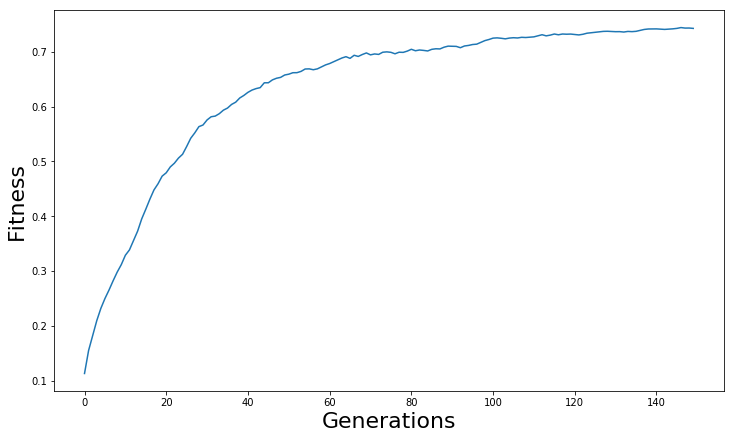

In [207]:
plt.figure(figsize=(12,7))
plt.xlabel("Generations",fontsize=22)
plt.ylabel("Fitness",fontsize=22)
plt.plot(pop_fit)

##### Listing 6.5

In [3]:
import torch

In [4]:
4*100 + 100 + 100*150 + 150 + 150*2 + 2

15952

In [161]:
4*25 + 25 + 10*25 + 10 + 2*10 + 2

407

In [492]:
def unpack_params(params, layers=[(25,4),(10,25),(2,10)]):
    unpacked_params = []
    e = 0
    for i,l in enumerate(layers):
        s,e = e,e+np.prod(l)
        weights = params[s:e].view(l)
        s,e = e,e+l[0]
        bias = params[s:e]
        unpacked_params.extend([weights,bias])
    return unpacked_params

def model(x,unpacked_params):
    l1,b1,l2,b2,l3,b3 = unpacked_params
    y = torch.nn.functional.linear(x,l1,b1)
    y = torch.relu(y)
    y = torch.nn.functional.linear(y,l2,b2)
    y = torch.relu(y)
    y = torch.nn.functional.linear(y,l3,b3)
    y = torch.log_softmax(y,dim=0)
    return y

def spawn_population(N=50,size=407):
    pop = []
    for i in range(N):
        vec = torch.randn(size) / 2.0
        fit = 0
        p = {'params':vec, 'fitness':fit}
        pop.append(p)
    return pop

In [6]:
#model(torch.randn(4).T,unpack_params(torch.randn(15952)/10))

##### Listing 6.6

In [491]:
def recombine(x1,x2):
    x1 = x1['params']
    x2 = x2['params']
    l = x1.shape[0]
    split_pt = np.random.randint(l)
    child1 = torch.zeros(l)
    child2 = torch.zeros(l)
    child1[0:split_pt] = x1[0:split_pt]
    child1[split_pt:] = x2[split_pt:]
    child2[0:split_pt] = x2[0:split_pt]
    child2[split_pt:] = x1[split_pt:]
    return {'params':child1, 'fitness':0.0}, {'params':child2, 'fitness': 0}

def mutate(x, rate=0.01):
    x_ = x['params']
    num_to_change = int(rate * x_.shape[0])
    idx = np.random.randint(low=0,high=x_.shape[0],size=(num_to_change,))
    x_[idx] = torch.randn(num_to_change)/10.0
    x['params'] = x_
    return x

In [814]:
mutate({'fitness':5.0,'params':torch.arange(10).float()},rate=0.1)

{'fitness': 5.0,
 'params': tensor([ 0.0000,  1.0000,  2.0000, -0.1315,  4.0000,  5.0000,  6.0000,  7.0000,
          8.0000,  9.0000])}

In [8]:
x = torch.arange(10)
x[np.random.randint(0,10,(2,))] = -2
x

tensor([ 0,  1,  2,  3,  4, -2, -2,  7,  8,  9])

##### Listing 6.7

In [322]:
import torchvision as TV

In [332]:
mnist_data = TV.datasets.MNIST("MNIST/", train=True, download=False)
mnist_test = TV.datasets.MNIST("MNIST/", train=False, download=False)

Processing...
Done!


In [346]:
x = mnist_data.train_data[0:100].float().flatten(start_dim=1)
x /= x.max()
params = torch.randn(100*784 + 100 + 50*100 + 50 + 50*10 + 10) / 10.0
model(x,unpacked_params=unpack_params(params,layers=[(100,784),(50,100),(10,50)])).shape

torch.Size([100, 10])

In [347]:
lossfn = torch.nn.NLLLoss()

In [9]:
import gym

env = gym.make("CartPole-v0")

In [170]:
def softmax(x,tau=1.2):
    return torch.exp(x/tau) / torch.exp(x/tau).sum()

In [844]:
def test_model(agent,n=1):
    scores = 0
    n = 5
    for i in range(n):
        done = False
        state = torch.from_numpy(env.reset()).float()
        score = 0
        while not done:
            params = unpack_params(agent['params'])
            probs = model(state,params)
            action = torch.distributions.Categorical(probs=probs).sample()
            state_, reward, done, info = env.step(action.item())
            state = torch.from_numpy(state_).float()
            score += 1
        scores += score
    scores /= n
    return scores

def test_model2(agent):
    rids = np.random.randint(low=0,high=60000,size=(100,))
    x = mnist_data.train_data[rids].float().flatten(start_dim=1)
    x /= x.max()
    #25*784 + 25 + 20*25 + 20 + 20*10 + 10
    #params = torch.randn(100*784 + 100 + 50*100 + 50 + 50*10 + 10) / 10.0
    p = unpack_params(agent['params'],layers=[(25,784),(20,25),(10,20)])
    pred = model(x,unpacked_params=p)
    y = mnist_data.train_labels[rids]
    loss = lossfn(pred,y)
    return loss

def evaluate_population(pop):
    tot_fit = 0
    lp = len(pop)
    scores = []
    for agent in pop:
        score = test_model(agent)
        agent['fitness'] = score
        tot_fit += score
        scores.append(score)
    scores = np.array(scores)
    avg_fit = tot_fit / lp
    return pop, avg_fit

def next_generation2(pop,mut_rate=0.0,tau=20):
    new_pop = []
    while len(new_pop) < len(pop):
        probs = 1.0 - softmax(torch.Tensor([x['fitness'] for x in pop]),tau=tau)
        probs = softmax(probs,tau=tau).detach().numpy()
        parents = np.random.choice(np.arange(len(pop)), size=2, replace=False, p = probs)
        parent0,parent1 = pop[parents[0]],pop[parents[1]]
        offspring_ = recombine(parent0,parent1)
        child1 = mutate(offspring_[0], rate=mut_rate)
        child2 = mutate(offspring_[1], rate=mut_rate)
        offspring = [child1, child2]
        new_pop.extend(offspring)
    return new_pop

def next_generation(pop,mut_rate=0.0,tau=20):
    new_pop = []
    lp = len(pop)
    while len(new_pop) < len(pop):
        rids = np.random.randint(low=0,high=lp,size=(int(0.2*lp)))
        #batch_ = pop[rids]
        batch = np.array([[i,x['fitness']] for (i,x) in enumerate(pop) if i in rids])
        #scores = np.array([x['fitness'] for x in batch])
        scores = batch[batch[:, 1].argsort()]
        i0, i1 = int(scores[-1][0]),int(scores[-2][0])
        parent0,parent1 = pop[i0],pop[i1]
        offspring_ = recombine(parent0,parent1)
        #child1,child2 = offspring_
        child1 = mutate(offspring_[0], rate=mut_rate)
        child2 = mutate(offspring_[1], rate=mut_rate)
        offspring = [child1, child2]
        new_pop.extend(offspring)
    return new_pop

In [835]:
test_model(pop[0])

10.2

In [836]:
#407, 20355
pop = spawn_population(N=50,size=407)

In [837]:
#pop[0]

In [838]:
pop, avg_fit = evaluate_population(pop)

In [839]:
#pop[0]

In [840]:
pop = next_generation(pop,tau=2.0)

In [695]:
pop[0]['params'].shape

torch.Size([20355])

In [540]:
unpacked_params=unpack_params(pop[0]['params'])

In [541]:
model(torch.randn(784),unpacked_params=unpack_params(pop[0]['params'],[(25,784),(20,25),(10,20)]))

tensor([-1.3802e+01, -1.9736e+01, -2.8192e+01, -2.2455e+01, -2.9587e+01,
        -2.0290e+01, -5.1177e+01, -1.6032e-02, -2.5763e+01, -4.1412e+00])

In [542]:
#np.array([x['fitness'] for x in pop])

In [543]:
pop[3]['params'].shape

torch.Size([20355])

In [544]:
score = test_model(pop[3])
score

tensor(23.3850)

In [571]:
np.array([x['fitness'] for x in pop])

array([24.924002 , 23.077421 , 18.767672 , 18.111404 , 20.924532 ,
       20.819809 , 16.94826  , 15.128842 , 21.195002 , 19.789486 ,
       16.615818 , 19.01187  , 15.509182 , 18.50777  , 20.348347 ,
       23.037012 , 32.777363 , 14.465524 , 21.231054 , 16.594902 ,
       25.661257 , 23.871231 , 21.998198 , 18.3474   , 14.749103 ,
       21.832695 , 14.571891 , 17.703585 , 12.61941  , 20.1872   ,
       16.195745 , 20.205597 , 20.414392 , 24.156153 , 16.840408 ,
       21.297243 , 23.412085 , 24.184345 , 16.833782 , 22.892296 ,
       23.54604  , 17.045483 , 20.732166 , 25.49101  , 14.3639345,
       13.463415 , 25.544876 , 19.42682  , 24.488724 , 28.36776  ],
      dtype=float32)

In [548]:
softmax(torch.Tensor([x['fitness'] for x in pop]),tau=0.2)

tensor([0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200,
        0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200,
        0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200,
        0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200,
        0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200,
        0.0200, 0.0200, 0.0200, 0.0200, 0.0200])

##### Listing 6.8

In [845]:
%%time
num_generations = 25
population_size = 500
mutation_rate = 0.01 #A
pop_fit = []
pop = spawn_population(N=population_size,size=407) #B
for i in range(num_generations):
    pop, avg_fit = evaluate_population(pop)
    pop_fit.append(avg_fit) #C
    pop = next_generation(pop, mut_rate=mutation_rate,tau=5.)

KeyboardInterrupt: 

In [ ]:
pop, avg_fit = evaluate_population(pop)

In [ ]:
#pop[0:5]

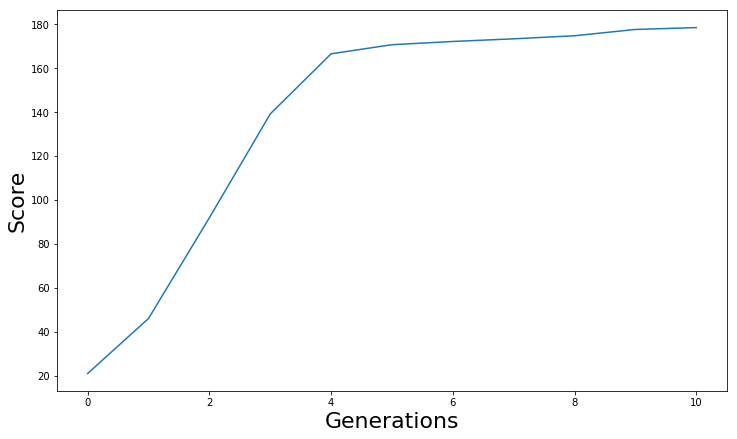

In [858]:
plt.figure(figsize=(12,7))
plt.xlabel("Generations",fontsize=22)
plt.ylabel("Score",fontsize=22)
plt.plot(running_mean(np.array(pop_fit),3))

In [848]:
test_model(pop[0])

189.2

##### Listing 6.9

##### Listing 6.10

##### Listing 6.11

##### Listing 6.12

##### Listing 6.13

##### Listing 6.14

In [204]:
def running_mean(x,n=5):
    conv = np.ones(n)
    y = np.zeros(x.shape[0]-n)
    for i in range(x.shape[0]-n):
        y[i] = (conv @ x[i:i+n]) / n
    return y